In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imprt the required libraries
import pandas as pd
import zipfile

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import optim
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from nltk.translate import chrf_score,bleu_score
import re

import os
from typing import Iterable, List
import math
import nltk.translate.chrf_score
import pathlib as pl
import random

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import random
import csv
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# selected_df = df

# Save the DataFrame to a CSV file
file_path = '/content/drive/MyDrive/AML/dataframe.csv'

# selected_df.to_csv(file_path, index=False)  # index=False to exclude the index column

In [ ]:
# df = og_df.head(10000)  # Change 3 to the desired number of rows

# # Set columns of the DataFrame
# df.columns = ['input', 'labels']

# Save the DataFrame to a CSV file
file_path = '/content/drive/MyDrive/AML/small_dataframe.csv'

# df.to_csv(file_path, index=False)  # Set index=False to exclude the index column

In [ ]:
# Load the DataFrame from the CSV file
og_df = pd.read_csv(file_path)

In [ ]:
value = og_df.at[37, 'input']
print(value)
value = og_df.at[37, 'labels']
print(value)

# Convert the DataFrame to a 2D list
lines = og_df.values.tolist()

It's social infrastructure entails reputed schools, finest healthcare centres, high-end hotels, shopping malls and recreational complexes.
The social infrastructure of the region entails reputed schools, finest healthcare centres, high-end hotels, shopping malls and recreational complexes.


In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# Turn a Unicode string to plain ASCII, thanks to
# The files are all in Unicode, to simplify we will turn Unicode characters to ASCII,
#  make everything lowercase, and trim most punctuation.

# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [ ]:
#  maximum length is 20 words (that includes ending punctuation) and we’re filtering
#  to sentences that translate to the form “I am” or “He is” etc. (accounting for
# apostrophes replaced earlier).

MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH #and \
        #p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
# The full process for preparing the data is:
# Normalize text, filter by length and content
# Make word lists from sentences in pairs

def prepareData(lines):
    # Normalize the strings
    pairs = [[normalizeString(row[0]), normalizeString(row[1])] for row in lines]
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    return pairs

pairs = prepareData(lines)
print(random.choice(pairs))

column_names = ['incorrect', 'correct']

# Split the data into training and testing sets (80% train, 20% test)
train_pairs, test_pairs = train_test_split(pairs, test_size=0.01, random_state=42)

train_df = pd.DataFrame(train_pairs, columns=column_names)
test_df = pd.DataFrame(test_pairs, columns=column_names)


Read 10000 sentence pairs
Trimmed to 5305 sentence pairs
Counting words...
['cone clutches were made they are used in various manual transmissions as synchronisers', 'cone clutches are used in various manual transmissions as synchronisers']


In [ ]:
train_df

,incorrect,correct
0,students study a range insect collection toz w...,students studied a range of topics from insect...
1,i m so happy to get able to come to disneyland,i m so happy to be able to come to disneyland
2,nativity where did the journey really ? start ?,nativity where did the journey really start ?
3,summer courses will probably your best bet it ...,summer courses will probably be your best bet ...
4,please ensure you have the carers permission b...,please ensure you have the carers permission b...
...,...,...
5246,we have appreciate you making the effort to sh...,we appreciate you making the effort to share t...
5247,so many wonder toys lorca is batman confirmed,so many wonderful toys lorca is batman confirmed
5248,productivity apps can help you and complete yo...,productivity apps can help you stay focused an...
5249,i like a parka but i can t justify a new coatw...,i like a parka but i can t justify a new coat ...


In [ ]:
SRC_LANGUAGE = 'incorrect'
TGT_LANGUAGE = 'correct'

In [ ]:
# Place-holders
vocab_transform = {}

token_transform = get_tokenizer('spacy', language='en_core_web_sm')


In [ ]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform(data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [ ]:
# Assuming train_iter is your iterable containing data from the CSV file
# Adjust the CSV file path and columns accordingly

train_iter = [(row[SRC_LANGUAGE], row[TGT_LANGUAGE]) for _, row in train_df.iterrows()]

# Create vocabularies for both source and target languages
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_iter, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True
    )

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
# Access the vocabularies
src_vocab = vocab_transform[SRC_LANGUAGE]
tgt_vocab = vocab_transform[TGT_LANGUAGE]

# Vocabulary sizes
print("Source vocabulary size:", len(src_vocab))
print("Target vocabulary size:", len(tgt_vocab))

Source vocabulary size: 13456
Target vocabulary size: 12382


In [ ]:
# As seen in the Data Sourcing and Processing section, our data iterator yields a pair of raw strings.
#  We need to convert these string pairs into the batched tensors that can be processed by our Seq2Seq
#  network defined previously. Below we define our collate function that converts a batch of raw strings
#   into batch tensors that can be fed directly into our model.

from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform, #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
text = ('The social infrastructure','healthcare centres')
src,tgt = collate_fn([text])
print(src,tgt)

tensor([[  2],
        [  0],
        [770],
        [  0],
        [  3]]) tensor([[   2],
        [2629],
        [   0],
        [   3]])


In [ ]:
# ransformer is a Seq2Seq model introduced in “Attention is all you need” paper
#  for solving machine translation tasks. Below, we will create a Seq2Seq network
#   that uses Transformer
# the output of the Transformer model is passed through linear layer that gives
# unnormalized probabilities for each token in the target language.

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
# During training, we need a subsequent word mask that will prevent the model
# from looking into the future words when making predictions. We will also need
# masks to hide source and target padding tokens. Below, let’s define a function
#  that will take care of both.

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
# Define the parameters of our model and instantiate the same. Below,
#  we also define our loss function which is the cross-entropy loss and the
#  optimizer used for training.

torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Define training and evaluation loop that
#  will be called for each epoch.

from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = [(row[SRC_LANGUAGE], row[SRC_LANGUAGE]) for _, row in train_df.iterrows()]
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))



In [ ]:
# Now we will evaluate the test data on the traied model
def evaluate(model):
    model.eval()
    losses = 0

    val_iter = [(row[SRC_LANGUAGE], row[SRC_LANGUAGE]) for _, row in test_df.iterrows()]
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [ ]:
# Now we have all the ingredients to train
#  our model.

from timeit import default_timer as timer
NUM_EPOCHS = 20

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 7.099, Val loss: 5.772, Epoch time = 22.226s
Epoch: 2, Train loss: 5.840, Val loss: 4.445, Epoch time = 20.714s
Epoch: 3, Train loss: 4.653, Val loss: 3.652, Epoch time = 26.433s
Epoch: 4, Train loss: 3.841, Val loss: 2.936, Epoch time = 22.547s
Epoch: 5, Train loss: 3.209, Val loss: 2.485, Epoch time = 20.020s
Epoch: 6, Train loss: 2.707, Val loss: 2.604, Epoch time = 20.474s
Epoch: 7, Train loss: 2.335, Val loss: 2.078, Epoch time = 19.562s
Epoch: 8, Train loss: 2.038, Val loss: 1.837, Epoch time = 21.201s
Epoch: 9, Train loss: 1.818, Val loss: 2.510, Epoch time = 20.089s
Epoch: 10, Train loss: 1.635, Val loss: 2.304, Epoch time = 20.438s
Epoch: 11, Train loss: 1.478, Val loss: 2.253, Epoch time = 19.835s
Epoch: 12, Train loss: 1.356, Val loss: 2.513, Epoch time = 20.459s
Epoch: 13, Train loss: 1.241, Val loss: 2.202, Epoch time = 19.116s
Epoch: 14, Train loss: 1.164, Val loss: 1.821, Epoch time = 19.248s
Epoch: 15, Train loss: 1.085, Val loss: 1.713, Epoch time

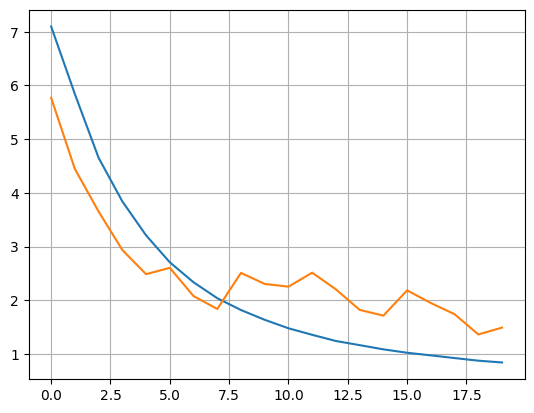

In [ ]:
# plotting loss training loss and validation loss
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.plot(train_losses)
_ = plt.plot(val_losses)
plt.grid()

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys



In [ ]:
# actual function to correct input sentence into target language
def correct(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
# Pick one in 18M examples
test_iter = [(row[SRC_LANGUAGE], row[SRC_LANGUAGE]) for _, row in test_df.iterrows()]

src,trg = random.choice(test_iter)

print("input: \"",src,"\"")
print("target: \"",trg,"\"")

prediction = correct(transformer, src)

print("prediction: \"%s\""%prediction)

input: " these are the reasons that compel on people to relay on branding agencies "
target: " these are the reasons that compel people to rely on branding agencies "
prediction: " these are the reasons that collectability on people to <unk> on comeback agencies "


In [ ]:
print(correct(transformer, "Stemware, case bulk discounts and more for your event."))

 active selecting case bulk discounts and more for your event daffidill 


In [ ]:
# We can evaluate random sentences from the training set and print out the input,
#  target, and output to make some subjective quality judgements:
# we also find the chrf_score here

def evaluateRandomly(test_pairs, n = 30):
    score = 0
    for i in range(n):
        pair = random.choice(test_pairs)
        src, trg = pair
        print('>', src)
        print('=', trg)
        prediction = correct(transformer, src)
        score = score + chrf_score.sentence_chrf(prediction, trg)
        print('<', prediction)
        print('')
    return score

In [ ]:
""" Example1: """
example_1 = "grammar: This sentences, has bads grammar and spelling!"

prediction = correct(transformer, example_1)
print(prediction)

grammar, this sentences, has bad grammar and spelling!


In [ ]:
""" Example2: """

example_2 = "grammar: I am enjoys, writtings articles ons AI and I also enjoyed write articling on AI."

prediction = correct(transformer, example_2)
print(prediction)

grammar, I am enjoys, writtings articles on AI and I also enjoy write article on AI.


In [ ]:
# # chrf score which is similarity matrixs
chrf_score = evaluateRandomly(test_pairs)

In [ ]:
print(chrf_score)

29.32506697498334
